# Instructions

1. First create your python environment using Anaconda or Virtualenv with `python>=3.10`.
2. Install prerequisites: `pip install torch numpy matplotlib PyYAML`.
3. Install auxilary package "comblearn" on the project root: `python setup.py develop`.
4. Run "Initialization" part of the notebook.
5. For the first experiment (Learning Coverage Function) run Part 1 of the notebook.
6. For the second experiment (Maximizing Social Welfare) run Part 2 of the notebook.
7. For each experiment use the trial config to generate desired output.

## Initialization

In [1]:
import torch
import torch.nn as nn
import logging

from comblearn.env import CombinatorialAuction

logging.basicConfig(level=20)

## 1. Learning Coverage and Cut Functions

### Trial Config

In [2]:
# Try different configs to get the desired ouputs

config = {
    'prob': 'low', # ['low', 'mid', 'high'],
    'function': 'dpst', # ['dsf', 'edsf', 'egdsf', 'dpst']
    'true': 'coverage' # ['coverage', 'cut']
}

In [3]:
import yaml 

if config['true'] == 'coverage':
    with open("config_coverage.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader) 
else:
    with open("config_cut.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader) 

In [4]:
import comblearn.env


auction = CombinatorialAuction(cfg['auction'])

In [5]:
if config['prob'] == 'low':
    X, y = auction.data_handler.R['0']
    vfa = auction.bidders[0].vf
elif config['prob'] == 'mid':
    X, y = auction.data_handler.R['1']
    vfa = auction.bidders[1].vf
else:
    X, y = auction.data_handler.R['2']
    vfa = auction.bidders[2].vf
items = auction.items

In [6]:
n = X.shape[0]
tr = int(80/100 * n)
X_train = X[0: tr]
y_train = y[0: tr] 
X_test = X[tr:]
y_test = y[tr:] 

In [7]:
X.shape

torch.Size([1024, 31])

In [8]:
# If you wanna chekc the EDSF, run this part

from comblearn.data import ExtendedDSFValueFunction, ExtendedGeneralDSFValueFunction
from comblearn.data import DSFValueFunction, DeepSets

if config['function'] == 'edsf':
    vf = ExtendedDSFValueFunction(items, 60, [64, 64, 64, 64], 130).to("cuda")
elif config['function'] == 'egdsf':
    vf = ExtendedGeneralDSFValueFunction(items, 60, [64, 64, 64, 64, 10], 95).to("cuda")
elif config['function'] == 'dpst':
    vf = DeepSets(items, [64, 64, 64], [64, 64, 64]).to('cuda')
else:
    vf = DSFValueFunction(items, 60, [64, 64, 64], 95).to("cuda")

In [9]:
# In order to check the output before training

i = 10
vf(X[i]), y[i]

(tensor([[0.0457]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor(79., device='cuda:0'))

In [10]:
# Optimization

from torch.optim import Adam

optimizer = Adam(vf.parameters(), lr=0.01)
criterion = nn.L1Loss()

losses = []

for _ in range(4000):
    optimizer.zero_grad()
    yp = vf(X_train)
    loss = criterion(yp, y_train)
    loss.backward(retain_graph=True)
    losses.append(loss.item())
    optimizer.step()
    with torch.no_grad():
        vf.relu()
    print(loss)

/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([819])) that is different to the input size (torch.Size([819, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(85.4268, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(85.1839, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(84.4010, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(82.4342, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(77.9710, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(68.5378, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(50.9166, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(22.6287, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(56.3491, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(42.9729, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(14.9041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(25.4123, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(34.1231, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(37.4384, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(36.6752, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(32.3381, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(24.4725, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(14.8755

In [11]:
# To chek the loss on test set

yp = vf(X_test)
criterion(yp, y_test).cpu().detach().numpy()

/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([205])) that is different to the input size (torch.Size([205, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


array(16.69406, dtype=float32)

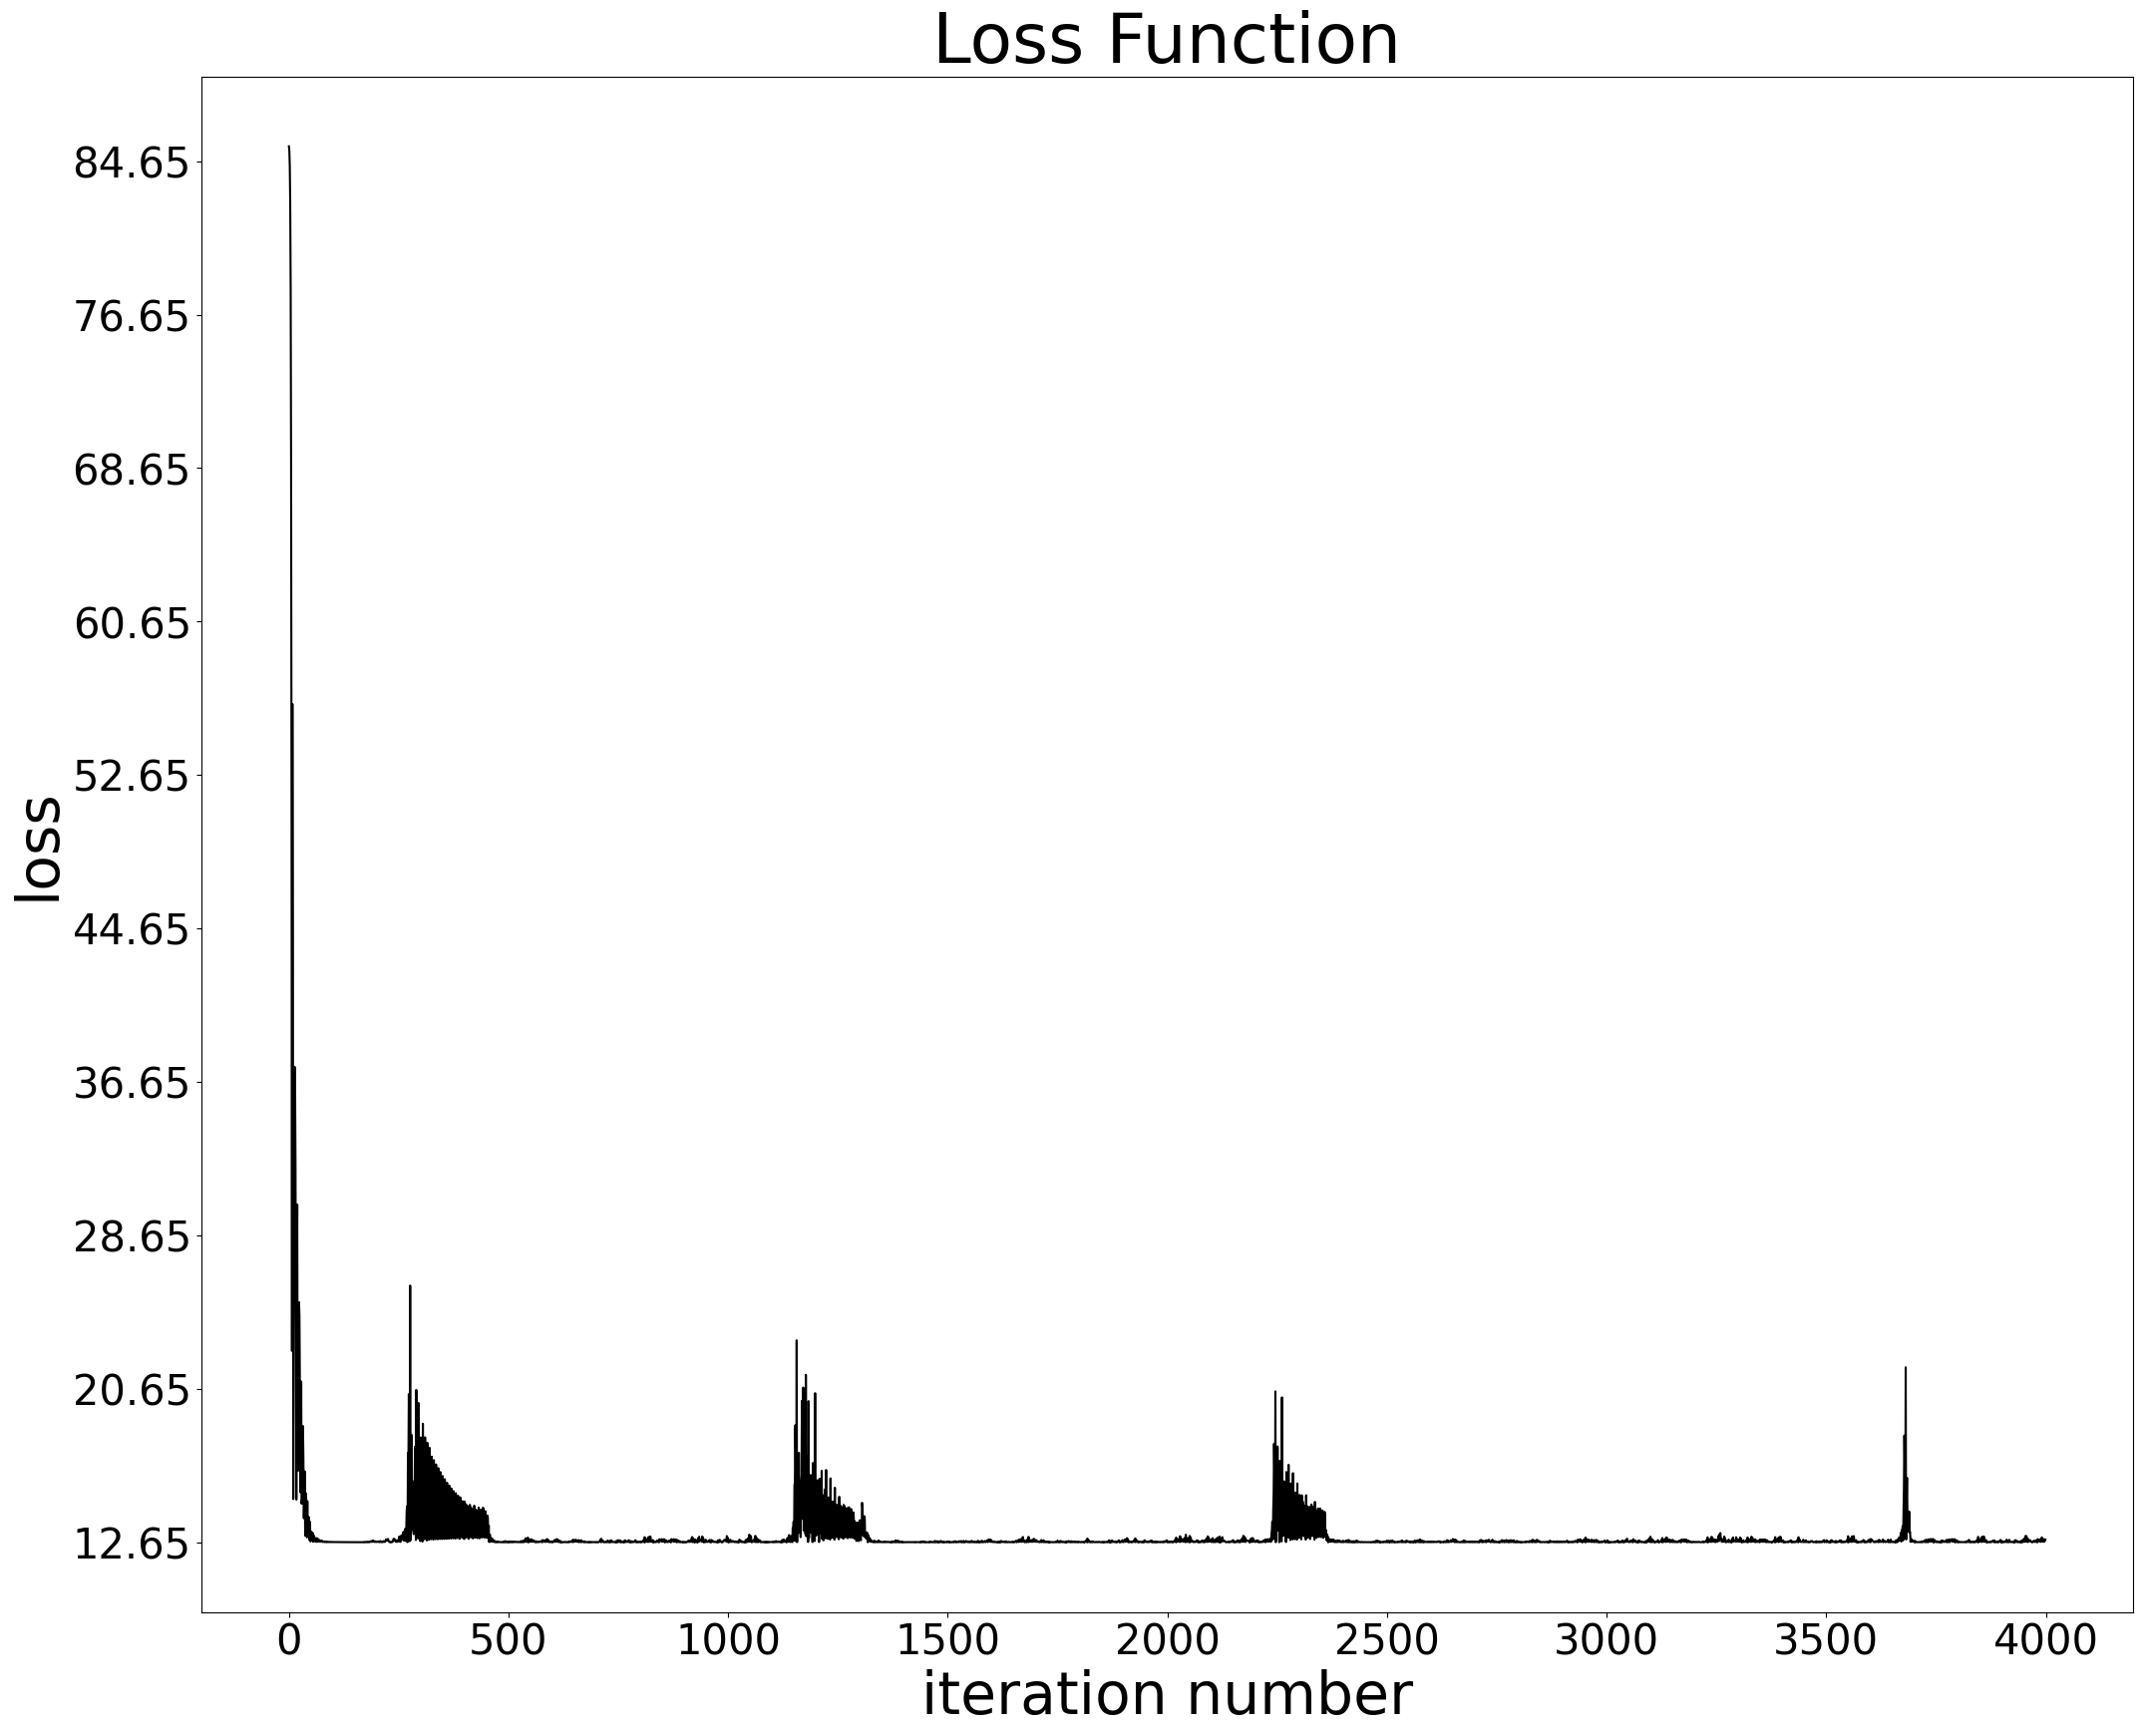

In [12]:
# To plot the loss throughout the iterations

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(losses))
plt.figure(figsize=(25, 20))
plt.title('Loss Function', fontdict={'size': 50})
plt.xlabel('iteration number', fontdict={'size': 42})
plt.ylabel('loss', fontdict={'size': 42})
plt.yticks(np.arange(min(losses), max(losses), (max(losses) - min(losses))//10 + 1), fontsize=30)
plt.xticks(fontsize=30)
plt.plot(x, losses, label='coverage_function', color='black')
plt.show()

In [13]:
# In order to check the output after training

i = 10
vf(X[i]), y[i]

(tensor([[92.9814]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor(79., device='cuda:0'))

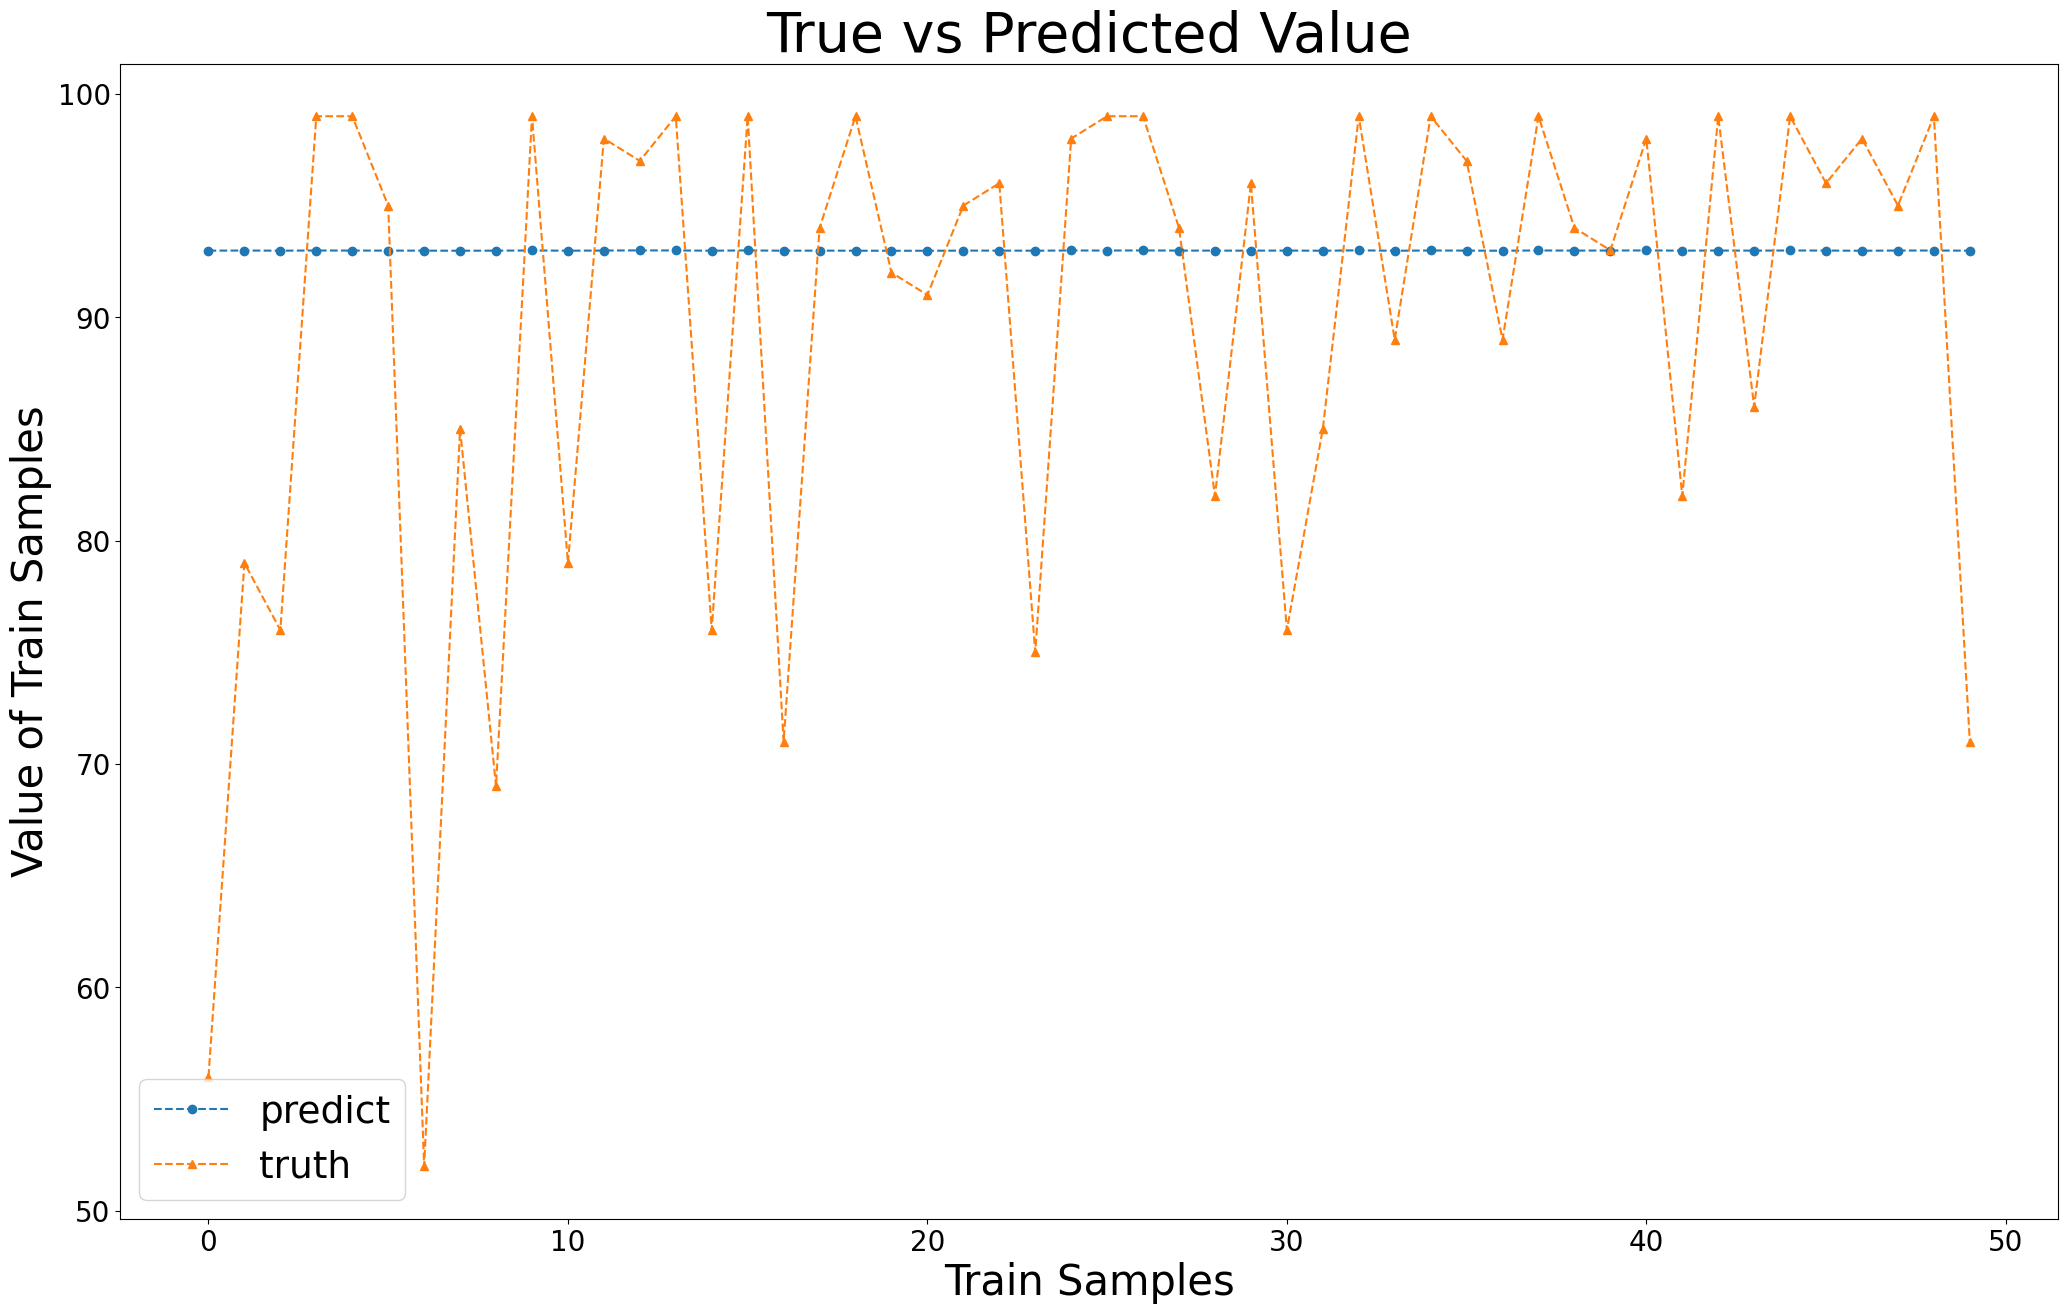

In [14]:
# To plot the value of some of the training data after training and compare them to the real values

import matplotlib.pyplot as plt

x = range(X_train[0: 50].shape[0])
y1 = vf(X_train[0: 50]).squeeze().tolist()
y2 = y_train[0: 50].squeeze().tolist()

plt.figure(figsize=(25, 15))

plt.title('True vs Predicted Value', fontdict={'size': 40})
plt.xlabel('Train Samples', fontdict={'size': 30})
plt.ylabel('Value of Train Samples', fontdict={'size': 30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(x, y1, 'o--', label = "predict")
plt.plot(x, y2, '^--', label = "truth")
plt.legend(loc='lower left', fontsize=27)
plt.show()

torch.Size([50, 1])


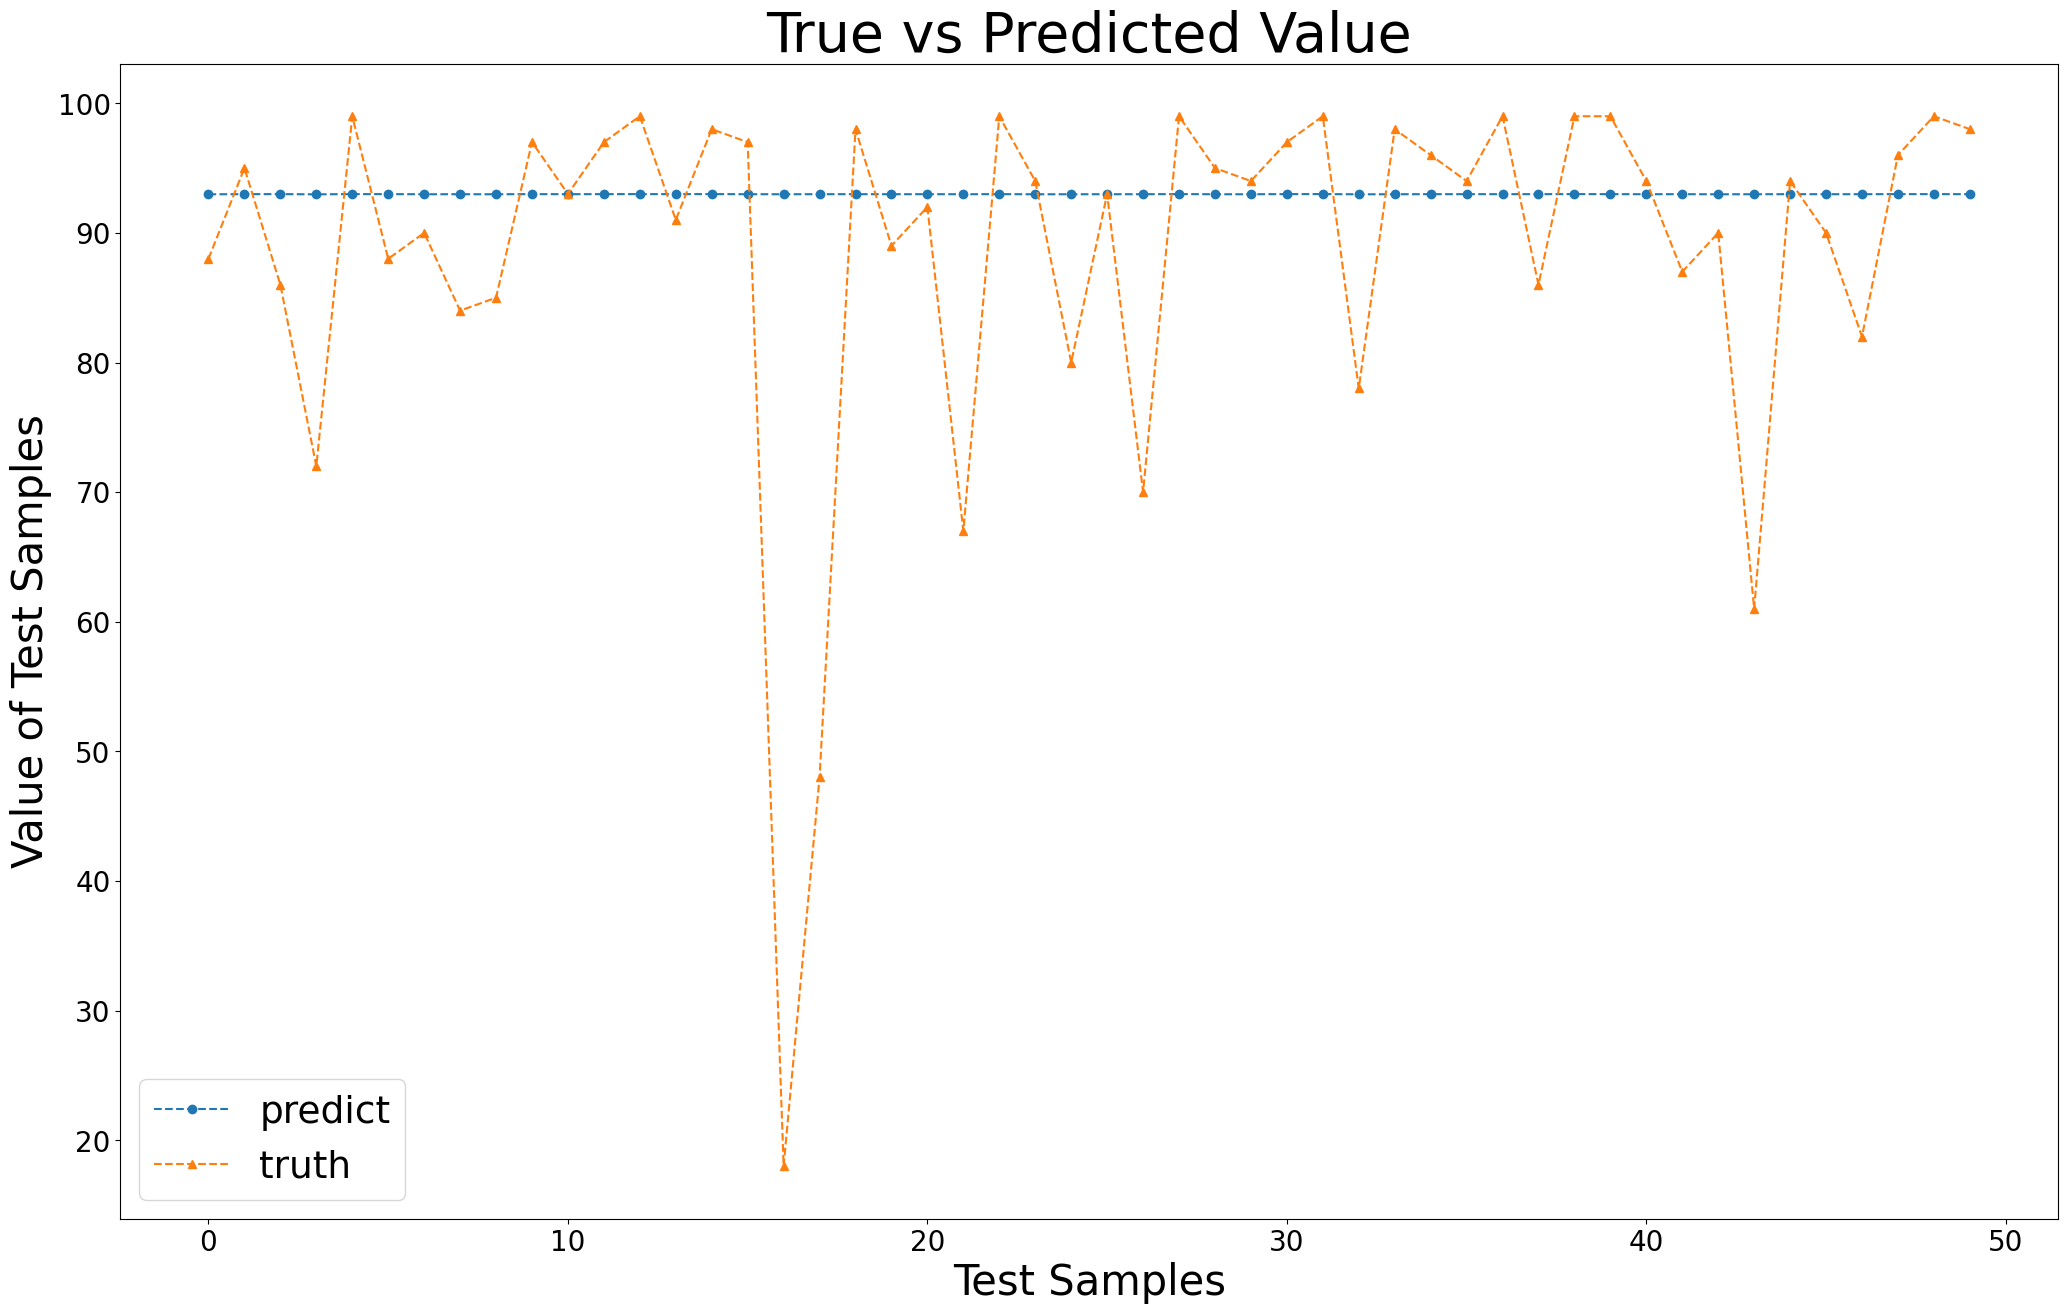

In [15]:
# To plot the value of some of the test data after training and compare them to the real values

import matplotlib.pyplot as plt

x = range(X_test[0: 50].shape[0])
y1 = vf(X_test[0: 50]).squeeze().tolist()
y2 = y_test[0: 50].tolist()
print(vf(X_test[0: 50]).size())

plt.figure(figsize=(25, 15))

plt.title('True vs Predicted Value', fontdict={'size': 40})
plt.xlabel('Test Samples', fontdict={'size': 30})
plt.ylabel('Value of Test Samples', fontdict={'size': 30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(x, y1, 'o--', label = "predict")
plt.plot(x, y2, '^--', label = "truth")
plt.legend(loc='lower left', fontsize=27)
plt.show()

### Multiple Running

In [4]:
from torch.nn import MSELoss
from torch.optim import Adam, SGD

from comblearn.data import ExtendedDSFValueFunction
from comblearn.data import DSFValueFunction

trial_no = 20

edsf_trial_losses = []
dsf_trial_losses = []

for _ in range(trial_no):
    print(f"Trial {_}:")
    auction = CombinatorialAuction(cfg['auction'])
    if config['prob'] == 'low':
        X, y = auction.data_handler.R['0']
        vfa = auction.bidders[0].vf
    elif config['prob'] == 'mid':
        X, y = auction.data_handler.R['1']
        vfa = auction.bidders[1].vf
    else:
        X, y = auction.data_handler.R['2']
        vfa = auction.bidders[2].vf
    items = auction.items

    for cf in ['edsf', 'dsf']:
        print(f'Config: {cf}')
        if cf == 'edsf':
            vf = ExtendedDSFValueFunction(items, 60, [64, 64, 64, 64], 95).to("cuda")
        else:
            vf = DSFValueFunction(items, 60, [64, 64, 64], 95).to("cuda")

        n = X.shape[0]
        tr = int(80/100 * n)
        X_train = X[0: tr]
        y_train = y[0: tr] 
        X_test = X[tr:]
        y_test = y[tr:] 

        optimizer = Adam(vf.parameters(), lr=0.01)
        criterion = nn.L1Loss()

        losses = []

        vf.train()
        for k in range(10000):
            optimizer.zero_grad()
            yp = vf(X_train)
            loss = criterion(yp, y_train)
            loss.backward(retain_graph=True)
            losses.append(loss.item())
            optimizer.step()
            with torch.no_grad():
                vf.relu()
            if k % 1000 == 0:
                print(loss)
        
        train_loss = losses[-1]

        vf.eval()
        yp = vf(X_test)
        test_loss = criterion(yp, y_test).item()

        if cf == 'edsf':
            edsf_trial_losses.append((train_loss, test_loss))
        else:
            dsf_trial_losses.append((train_loss, test_loss))

Trial 0:
Config: edsf
tensor(183.2988, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7489, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0217, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8616, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7738, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7803, device='cuda:0', grad_fn=<MeanBackward0>)
Config: dsf
tensor(40.3492, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([819])) that is different to the input size (torch.Size([819, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(38.8099, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8204, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8246, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8184, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9950, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9981, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0174, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0171, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([205])) that is different to the input size (torch.Size([205, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Trial 1:
Config: edsf
tensor(177.3650, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5699, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1686, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.0329, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7017, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8072, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8397, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3585, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1603, device='cuda:0', grad_fn=<MeanBackward0>)
Config: dsf
tensor(43.8551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8431, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.8417, device='cuda:0', grad_fn=<Mean

In [5]:
import numpy as np

x = [a for _, a in  edsf_trial_losses]

In [6]:
np.mean(x), np.std(x)

(1.044721081852913, 0.4242642483464915)

## 2. Maximizing Social Welfare

### Config

In [2]:
config = {
    'function': 'dsf' # ['dsf', 'edsf', 'vnn', 'comp']
}

In [12]:
import yaml 

if config['function'] == 'edsf':
    with open("config_edsf_social_welfare.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)
elif config['function'] == 'vnn':
    with open("config_vnn_social_welfare.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)
elif config['function'] == 'comp':
    with open("config_comp_social_welfare.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)
else: 
    with open("config_dsf_social_welfare.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)

In [13]:
device = "cuda"

def social_welfare(ws, allocation):
    return torch.sum(torch.tensor([w(alloc) for w, alloc in zip(ws, allocation)]).to(device))

In [18]:
auction = CombinatorialAuction(cfg['auction'])

social welfare is: 65.0, iteration is: 1000
social welfare is: 96.0, iteration is: 2000
social welfare is: 89.0, iteration is: 3000
social welfare is: 88.0, iteration is: 4000
social welfare is: 98.0, iteration is: 5000
social welfare is: 82.0, iteration is: 6000
[tensor([0., 1., 0., 0., 0., 1., 0., 0.], device='cuda:0'), tensor([0., 0., 1., 0., 1., 0., 0., 1.], device='cuda:0'), tensor([1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 110.0


### Randomized Greedy

In [6]:
allocation, social_welfare = auction.run()

INFO:root:Final allocation calculation...


KeyboardInterrupt: 

In [ ]:
social_welfare, allocation

### Gradient Ascent

In [6]:
auction.allocation_config['scheme'] = 'GradientAscent'
auction.allocation_config['optimizer'] = 'comblearn.optim.GradientAscentOptimizer'  # Change this to batch if you want to perform a batch optimization
auction.allocation_config['learning-rate'] = 0.001
auction.allocation_config['batch-size'] = 100
auction.allocation_config['eps'] = 0.00

In [7]:
allocation, social_welfare, allocation1, social_welfare1 = auction.run()
# allocation, social_welfare = auction.run()

INFO:root:Final allocation calculation...


INFO:root:Bidder 0, loss: 4.463435649871826
INFO:root:Bidder 1, loss: 5.187432289123535
INFO:root:Bidder 2, loss: 9.029970169067383


output is: 1683.638671875, iteration is: 0
output is: 1750.4521484375, iteration is: 1000
output is: 1753.3702392578125, iteration is: 2000
output is: 1754.818603515625, iteration is: 3000
output is: 1751.706298828125, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[0.0044, 0.9956, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0074, 0.9926, 0.0000],
        [0.2766, 0.0129, 0.7106],
        [0.0190, 0.8629, 0.1181],
        [0.0057, 0.0113, 0.9830],
        [0.0031, 0.0118, 0.9851],
        [0.9913, 0.0087, 0.0000]], device='cuda:0', requires_grad=True)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
INFO:root:Bidder 0, loss: 118.375
INFO:root:Bidder 1, loss: 163.12673950195312
INFO:root:Bidder 2, loss: 113.96297454833984


output is: 2054.6669921875, iteration is: 0
output is: 2054.6669921875, iteration is: 1000
output is: 2054.6669921875, iteration is: 2000
output is: 2054.6669921875, iteration is: 3000
output is: 2054.6669921875, iteration is: 4000
Final Distribution: tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0', requires_grad=True)


In [8]:
allocation, social_welfare, allocation1, social_welfare1

({'0': tensor([0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0'),
  '1': tensor([1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'),
  '2': tensor([0., 0., 0., 1., 0., 1., 1., 0.], device='cuda:0')},
 tensor(1766., device='cuda:0'),
 {'0': tensor([0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0'),
  '1': tensor([1., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0'),
  '2': tensor([0., 1., 1., 1., 0., 0., 1., 1.], device='cuda:0')},
 tensor(1592., device='cuda:0'))

In [10]:
from comblearn.env import BruteForceOptimizer


ws = [b.vf for b in auction.bidders]

optim_aux = BruteForceOptimizer(len(auction.items), len(auction.bidders), ws)
opt_alloc = optim_aux.optimize()
opt_sw = optim_aux._social_welfare(opt_alloc)

opt_sw

social welfare is: 1094.0, iteration is: 1000
social welfare is: 1525.0, iteration is: 2000
social welfare is: 1513.0, iteration is: 3000
social welfare is: 1544.0, iteration is: 4000
social welfare is: 1695.0, iteration is: 5000
social welfare is: 1507.0, iteration is: 6000
[tensor([0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')]


tensor(1771.)

In [9]:
social_welfare / 96#, social_welfare1 / 96

tensor(0.8021, device='cuda:0')

In [ ]:
allocation1, social_welfare1

In [ ]:
print(f'optimal social welfare for auction with coverage value funciton is: {social_welfare}')
print(f'final allocation for auction with coverage value functions is: {allocation}')

IF you wanna run the auction for a desired number of times (here 10), and compare the ouptut of gradient ascent to the optimal ouput (result of brute force).

In [6]:
from comblearn.env import BruteForceOptimizer

output = []
for i in range(10):
    auction = CombinatorialAuction(cfg['auction'])
    optimal_social_welfare = auction.data_handler.opt_sw
    # _, rg_social_welfare = auction.run()
    auction.allocation_config['scheme'] = 'GradientAscent'
    auction.allocation_config['optimizer'] = 'comblearn.optim.GradientAscentOptimizer'  # Change this to batch if you want to perform a batch optimization
    auction.allocation_config['learning-rate'] = 0.001
    auction.allocation_config['batch-size'] = 100
    auction.allocation_config['eps'] = 0.00
    _, social_welfare, _,  social_welfare1 = auction.run()
    ws = [b.vf for b in auction.bidders]

    optim_aux = BruteForceOptimizer(len(auction.items), len(auction.bidders), ws)
    opt_alloc = optim_aux.optimize()
    opt_learn_sw = optim_aux._social_welfare(opt_alloc)

    output.append((social_welfare, social_welfare1, opt_learn_sw, optimal_social_welfare))

    print('A:', (social_welfare, social_welfare1, opt_learn_sw, optimal_social_welfare))

social welfare is: 1091.0, iteration is: 1000
social welfare is: 1512.0, iteration is: 2000
social welfare is: 1524.0, iteration is: 3000
social welfare is: 1546.0, iteration is: 4000
social welfare is: 1700.0, iteration is: 5000
social welfare is: 1518.0, iteration is: 6000


INFO:root:Final allocation calculation...


[tensor([0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 1., 0., 1., 1., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 1776.0


INFO:root:Bidder 0, loss: 4.903818607330322
INFO:root:Bidder 1, loss: 2.1733860969543457
INFO:root:Bidder 2, loss: 5.2958173751831055


output is: 1705.123779296875, iteration is: 0
output is: 1797.984130859375, iteration is: 1000
output is: 1797.649658203125, iteration is: 2000
output is: 1797.8095703125, iteration is: 3000
output is: 1797.6328125, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[0.4074, 0.5926, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.9969, 0.0031, 0.0000],
        [0.0029, 0.0033, 0.9938],
        [0.0050, 0.0046, 0.9904],
        [0.2507, 0.0021, 0.7472]], device='cuda:0', requires_grad=True)


INFO:root:Bidder 0, loss: 125.40169525146484
INFO:root:Bidder 1, loss: 180.5
INFO:root:Bidder 2, loss: 128.9114990234375


output is: 2035.0810546875, iteration is: 0
output is: 2035.0810546875, iteration is: 1000
output is: 2035.0810546875, iteration is: 2000
output is: 2035.0810546875, iteration is: 3000
output is: 2035.0810546875, iteration is: 4000
Final Distribution: tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0', requires_grad=True)
social welfare is: 1091.0, iteration is: 1000
social welfare is: 1512.0, iteration is: 2000
social welfare is: 1524.0, iteration is: 3000
social welfare is: 1546.0, iteration is: 4000
social welfare is: 1700.0, iteration is: 5000
social welfare is: 1518.0, iteration is: 6000
[tensor([0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 1., 0., 1., 1., 0.], de

INFO:root:Final allocation calculation...


[tensor([1., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 1., 0., 1., 1.], device='cuda:0'), tensor([0., 1., 1., 0., 0., 1., 0., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 1789.0


INFO:root:Bidder 0, loss: 6.833057403564453
INFO:root:Bidder 1, loss: 9.888274192810059
INFO:root:Bidder 2, loss: 5.780449867248535


output is: 1727.8291015625, iteration is: 0
output is: 1807.833984375, iteration is: 1000
output is: 1807.82080078125, iteration is: 2000
output is: 1807.790283203125, iteration is: 3000
output is: 1807.818603515625, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.0137, 0.9863],
        [0.0000, 1.0000, 0.0000],
        [0.6089, 0.3911, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.0072, 0.9928],
        [0.0000, 0.4520, 0.5480],
        [0.0000, 1.0000, 0.0000]], device='cuda:0', requires_grad=True)


INFO:root:Bidder 0, loss: 118.8125
INFO:root:Bidder 1, loss: 148.40625
INFO:root:Bidder 2, loss: 91.51866912841797


output is: 2085.353515625, iteration is: 0
output is: 2085.35693359375, iteration is: 1000
output is: 2085.3603515625, iteration is: 2000
output is: 2085.36376953125, iteration is: 3000
output is: 2085.3671875, iteration is: 4000
Final Distribution: tensor([[0.4372, 0.2814, 0.2814],
        [0.3870, 0.3065, 0.3065],
        [0.3847, 0.3077, 0.3077],
        [0.4067, 0.2966, 0.2966],
        [0.4486, 0.2757, 0.2757],
        [0.4404, 0.2798, 0.2798],
        [0.4215, 0.2892, 0.2892],
        [0.3921, 0.3039, 0.3039]], device='cuda:0', requires_grad=True)
social welfare is: 1084.0, iteration is: 1000
social welfare is: 1544.0, iteration is: 2000
social welfare is: 1491.0, iteration is: 3000
social welfare is: 1543.0, iteration is: 4000
social welfare is: 1719.0, iteration is: 5000
social welfare is: 1509.0, iteration is: 6000
[tensor([1., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 1., 0., 1., 1.], device='cuda:0'), tensor([0., 1., 1., 0., 0., 1., 0., 0.], devi

INFO:root:Final allocation calculation...


[tensor([0., 0., 1., 0., 0., 0., 1., 0.], device='cuda:0'), tensor([0., 1., 0., 0., 0., 1., 0., 1.], device='cuda:0'), tensor([1., 0., 0., 1., 1., 0., 0., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 1794.0


INFO:root:Bidder 0, loss: 3.002686023712158
INFO:root:Bidder 1, loss: 2.9397668838500977
INFO:root:Bidder 2, loss: 9.353094100952148


output is: 1720.819091796875, iteration is: 0
output is: 1822.8118896484375, iteration is: 1000
output is: 1822.94189453125, iteration is: 2000
output is: 1822.435546875, iteration is: 3000
output is: 1822.4140625, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[0.0000, 0.0000, 1.0000],
        [0.0000, 0.9924, 0.0076],
        [0.6424, 0.3372, 0.0204],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.1643, 0.8357],
        [0.0000, 1.0000, 0.0000],
        [0.9773, 0.0000, 0.0227],
        [0.0000, 0.9791, 0.0209]], device='cuda:0', requires_grad=True)


INFO:root:Bidder 0, loss: 131.78125
INFO:root:Bidder 1, loss: 183.203125
INFO:root:Bidder 2, loss: 139.5


output is: 2060.444091796875, iteration is: 0
output is: 2061.0087890625, iteration is: 1000
output is: 2061.361083984375, iteration is: 2000
output is: 2061.45947265625, iteration is: 3000
output is: 2061.4677734375, iteration is: 4000
Final Distribution: tensor([[2.4957e-02, 1.3947e-01, 8.3557e-01],
        [1.2103e-01, 9.5264e-02, 7.8371e-01],
        [9.0477e-02, 1.3572e-01, 7.7380e-01],
        [1.0359e-01, 2.0775e-01, 6.8866e-01],
        [2.3733e-01, 4.9323e-01, 2.6944e-01],
        [6.3432e-04, 0.0000e+00, 9.9937e-01],
        [9.5591e-02, 1.2187e-01, 7.8253e-01],
        [7.7311e-02, 1.9017e-01, 7.3252e-01]], device='cuda:0',
       requires_grad=True)
social welfare is: 1099.0, iteration is: 1000
social welfare is: 1567.0, iteration is: 2000
social welfare is: 1497.0, iteration is: 3000
social welfare is: 1496.0, iteration is: 4000
social welfare is: 1725.0, iteration is: 5000
social welfare is: 1506.0, iteration is: 6000
[tensor([0., 0., 1., 0., 0., 0., 1., 0.], device='cuda

INFO:root:Final allocation calculation...


[tensor([0., 1., 1., 0., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 1., 1., 0., 0., 1.], device='cuda:0'), tensor([1., 0., 0., 0., 0., 1., 1., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 1781.0


INFO:root:Bidder 0, loss: 2.2788920402526855
INFO:root:Bidder 1, loss: 2.1824426651000977
INFO:root:Bidder 2, loss: 2.07528018951416


output is: 1717.11669921875, iteration is: 0
output is: 1796.3046875, iteration is: 1000
output is: 1796.5146484375, iteration is: 2000
output is: 1795.029296875, iteration is: 3000
output is: 1796.5263671875, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[0.0000, 0.9912, 0.0088],
        [0.0000, 0.9893, 0.0107],
        [0.9869, 0.0000, 0.0131],
        [0.2352, 0.7555, 0.0093],
        [0.0000, 0.9863, 0.0137],
        [0.0000, 0.0000, 1.0000],
        [0.1979, 0.0000, 0.8021],
        [0.0000, 0.0000, 1.0000]], device='cuda:0', requires_grad=True)


INFO:root:Bidder 0, loss: 136.59375
INFO:root:Bidder 1, loss: 182.578125
INFO:root:Bidder 2, loss: 125.40625


output is: 2147.640869140625, iteration is: 0
output is: 2149.35400390625, iteration is: 1000
output is: 2149.7734375, iteration is: 2000
output is: 2149.7822265625, iteration is: 3000
output is: 2149.757568359375, iteration is: 4000
Final Distribution: tensor([[3.2462e-02, 1.3873e-03, 9.6615e-01],
        [1.3105e-01, 2.1590e-01, 6.5305e-01],
        [4.8606e-02, 1.7043e-01, 7.8097e-01],
        [1.0763e-01, 3.2826e-02, 8.5954e-01],
        [4.8555e-02, 1.7712e-01, 7.7432e-01],
        [7.0037e-02, 4.7129e-02, 8.8283e-01],
        [7.0062e-02, 2.0428e-03, 9.2789e-01],
        [2.0890e-04, 4.4960e-01, 5.5019e-01]], device='cuda:0',
       requires_grad=True)
social welfare is: 1078.0, iteration is: 1000
social welfare is: 1530.0, iteration is: 2000
social welfare is: 1525.0, iteration is: 3000
social welfare is: 1505.0, iteration is: 4000
social welfare is: 1733.0, iteration is: 5000
social welfare is: 1505.0, iteration is: 6000
[tensor([0., 1., 1., 0., 0., 0., 0., 0.], device='cuda:0'

INFO:root:Final allocation calculation...


[tensor([0., 0., 0., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0., 1., 0., 0.], device='cuda:0'), tensor([0., 1., 0., 0., 0., 0., 1., 1.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 1796.0


INFO:root:Bidder 0, loss: 5.277082443237305
INFO:root:Bidder 1, loss: 2.195687770843506
INFO:root:Bidder 2, loss: 5.981687545776367


output is: 1694.07470703125, iteration is: 0
output is: 1804.434326171875, iteration is: 1000
output is: 1804.4346923828125, iteration is: 2000
output is: 1804.43359375, iteration is: 3000
output is: 1804.432373046875, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[0.0000, 1.0000, 0.0000],
        [0.0000, 0.2091, 0.7909],
        [0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.3350, 0.6650, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000]], device='cuda:0', requires_grad=True)


INFO:root:Bidder 0, loss: 128.0
INFO:root:Bidder 1, loss: 166.487548828125
INFO:root:Bidder 2, loss: 105.2652359008789


output is: 2084.904541015625, iteration is: 0
output is: 2084.904541015625, iteration is: 1000
output is: 2084.904541015625, iteration is: 2000
output is: 2084.904541015625, iteration is: 3000
output is: 2084.904541015625, iteration is: 4000
Final Distribution: tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0', requires_grad=True)
social welfare is: 1112.0, iteration is: 1000
social welfare is: 1502.0, iteration is: 2000
social welfare is: 1504.0, iteration is: 3000
social welfare is: 1549.0, iteration is: 4000
social welfare is: 1687.0, iteration is: 5000
social welfare is: 1504.0, iteration is: 6000
[tensor([0., 0., 0., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0., 1., 0., 0.], device='cuda:0'), tensor([0., 1., 0., 0., 0., 0., 1

INFO:root:Final allocation calculation...


[tensor([0., 0., 0., 1., 0., 1., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([0., 1., 0., 0., 0., 0., 1., 1.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 1782.0


INFO:root:Bidder 0, loss: 2.5720391273498535
INFO:root:Bidder 1, loss: 8.225972175598145
INFO:root:Bidder 2, loss: 2.7204670906066895


output is: 1686.287353515625, iteration is: 0
output is: 1772.7130126953125, iteration is: 1000
output is: 1772.9134521484375, iteration is: 2000
output is: 1771.96728515625, iteration is: 3000
output is: 1772.45849609375, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[0.0000, 0.9986, 0.0014],
        [0.0000, 0.0649, 0.9351],
        [0.0000, 0.0090, 0.9910],
        [0.5317, 0.4632, 0.0051],
        [0.0000, 1.0000, 0.0000],
        [0.9313, 0.0611, 0.0076],
        [0.0000, 0.9954, 0.0046],
        [0.0000, 0.0050, 0.9950]], device='cuda:0', requires_grad=True)


INFO:root:Bidder 0, loss: 108.1875
INFO:root:Bidder 1, loss: 137.0
INFO:root:Bidder 2, loss: 84.171875


output is: 2100.5419921875, iteration is: 0
output is: 2101.12109375, iteration is: 1000
output is: 2101.6650390625, iteration is: 2000
output is: 2101.69140625, iteration is: 3000
output is: 2101.718994140625, iteration is: 4000


In [2]:
output

NameError: name 'output' is not defined

In [1]:
os = [(a.item(), b.item(), c.item(), d.item()) for a, b, c, d in output]

NameError: name 'output' is not defined

In [ ]:
os

In [ ]:
for i in range(5):
    print(f"|{i+1}| {os[i][0]}| {os[i][1]} | {os[i][2]} | {round(100 * os[i][0]/os[i][2],2)} | {round(100 * os[i][1]/os[i][2], 2)}")

In [ ]:
import numpy as np

print(f"|Avg|{np.mean([x[0] for x in os])}|{np.mean([x[1] for x in os])}|{np.mean([x[2] for x in os])}|{np.mean([round(100* x[0]/x[2]) for x in os])}|{np.mean([round(100* x[1]/x[2]) for x in os])}")

In [ ]:
gas = [a.item() for _, a, _ in output]
rgs = [a.item() for a, _, _ in output]

In [ ]:
import numpy as np

list(zip(rgs, gas))

In [ ]:
np.mean(gas), np.mean(rgs)

In [ ]:
s = 0
k = 0
print("Trial No,Predicted, Optimal, Efficiency")
for x,y in output:
    k += 1
    print(f"{k},\t{x.item()},\t{y.item()},\t{x.item() / y.item()}")
    s += x.item() / y.item()
s/15